# Example logic, proof of concept

In [7]:
import pandas as pd
import matplotlib.pyplot as plt 

from itertools import combinations
from collections import defaultdict

# Sample data
data = {
    'id': [1, 2, 3, 4, 5, 6],
    'location': ['remote', 'in-person', 'remote', 'in-person', 'remote', 'in-person'],
    'attendees': [['Alice', 'Bob'], ['Alice', 'Charlie', 'Dave'], ['Alice', 'Bob', 'Charlie'], ['Charlie', 'Dave'], ['Bob', 'Dave'], ['Alice', 'Bob', 'Charlie', 'Dave']],
    'length': [30, 45, 60, 90, 120, 150]
}

df = pd.DataFrame(data)

# Add a new column 'num_attendees' to count the number of attendees in each meeting
df['num_attendees'] = df['attendees'].apply(len)

### Pt. 1- Frequent pairs in group settings 

In [8]:
# Initialize a dictionary to store the total time spent together
time_together = defaultdict(int)

# Iterate through each meeting
for index, row in df.iterrows():
    attendees = row['attendees']
    length = row['length']
    
    # Generate all pairs of attendees
    pairs = combinations(sorted(attendees), 2)
    
    # Add the length of the meeting to each pair
    for pair in pairs:
        time_together[pair] += length

# Convert to a sorted list of pairs by the time spent together
most_time_together = sorted(time_together.items(), key=lambda x: x[1], reverse=True)

# Display the result
print(most_time_together)


[(('Charlie', 'Dave'), 285), (('Bob', 'Dave'), 270), (('Alice', 'Charlie'), 255), (('Alice', 'Bob'), 240), (('Bob', 'Charlie'), 210), (('Alice', 'Dave'), 195)]


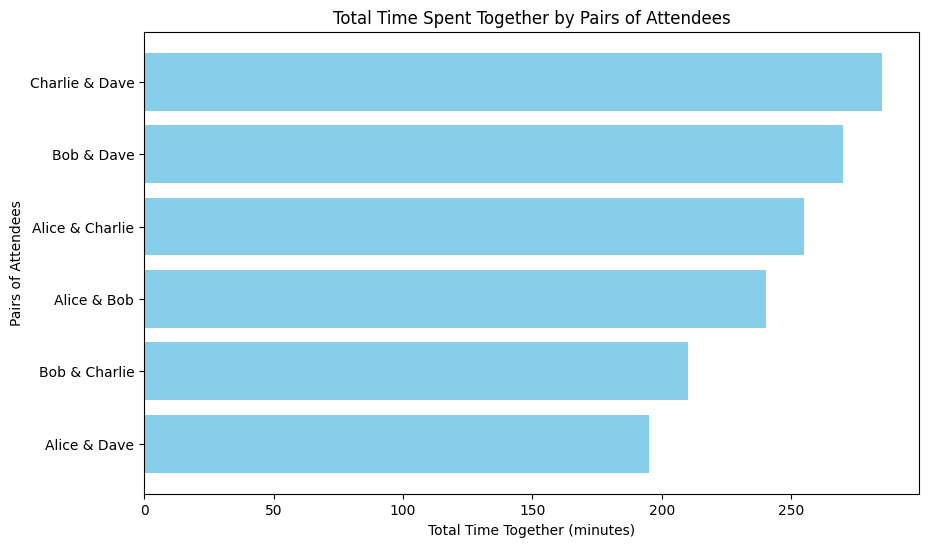

In [9]:
# Extract data for plotting
pairs = [f'{pair[0]} & {pair[1]}' for pair, _ in most_time_together]
times = [time for _, time in most_time_together]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.barh(pairs, times, color='skyblue')
plt.xlabel('Total Time Together (minutes)')
plt.ylabel('Pairs of Attendees')
plt.title('Total Time Spent Together by Pairs of Attendees')
plt.gca().invert_yaxis()  # To display the pair with the most time at the top
plt.show()

### p1.5 - Meetings with >2 attendees plus striation by number of attendees in meeting

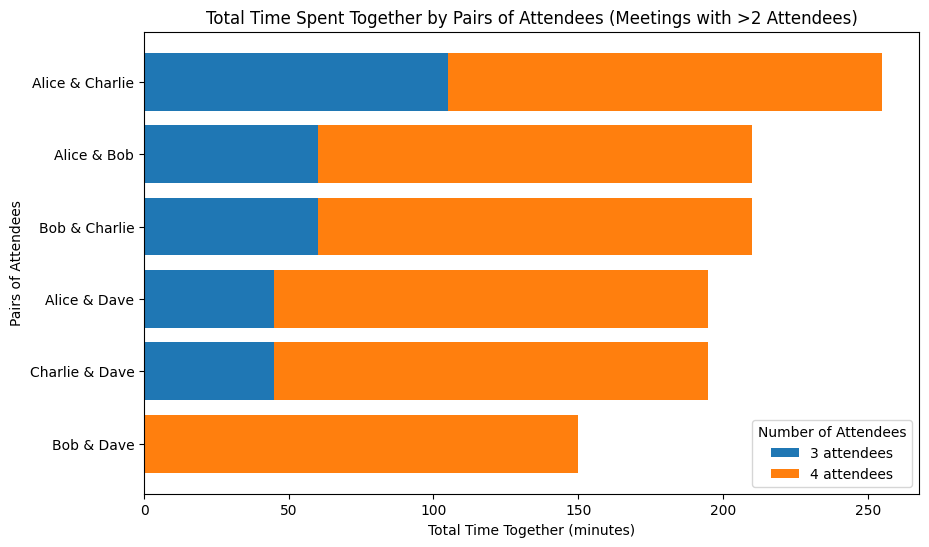

In [10]:
# Filter meetings with more than two attendees
df_filtered = df[df['num_attendees'] > 2]

# Initialize a nested dictionary to store the total time spent together by each pair, grouped by number of attendees
time_together_by_attendees = defaultdict(lambda: defaultdict(int))

# Iterate through each filtered meeting
for index, row in df_filtered.iterrows():
    attendees = row['attendees']
    length = row['length']
    num_attendees = row['num_attendees']
    
    # Generate all pairs of attendees
    pairs = combinations(sorted(attendees), 2)
    
    # Add the length of the meeting to each pair for the corresponding number of attendees
    for pair in pairs:
        time_together_by_attendees[pair][num_attendees] += length

# Calculate total time together for each pair across all groupings
total_time_by_pair = {pair: sum(times.values()) for pair, times in time_together_by_attendees.items()}

# Sort pairs by total time together
sorted_pairs = sorted(total_time_by_pair.keys(), key=lambda pair: total_time_by_pair[pair], reverse=True)

# Prepare data for plotting
num_attendees_groups = sorted(df_filtered['num_attendees'].unique())
time_by_group = {group: [] for group in num_attendees_groups}

for pair in sorted_pairs:
    for group in num_attendees_groups:
        time_by_group[group].append(time_together_by_attendees[pair][group])

# Plotting the stacked bar chart
plt.figure(figsize=(10, 6))

bottom = [0] * len(sorted_pairs)
for group in num_attendees_groups:
    plt.barh([f'{pair[0]} & {pair[1]}' for pair in sorted_pairs], time_by_group[group], left=bottom, label=f'{group} attendees')
    bottom = [i + j for i, j in zip(bottom, time_by_group[group])]

plt.xlabel('Total Time Together (minutes)')
plt.ylabel('Pairs of Attendees')
plt.title('Total Time Spent Together by Pairs of Attendees (Meetings with >2 Attendees)')
plt.legend(title='Number of Attendees')
plt.gca().invert_yaxis()  # To display the pair with the most time at the top
plt.show()

### Pt. 2 - Frequent remote interactions with no in-person

In [11]:
# Initialize a dictionary to store the count of meetings (remote/in-person) per pair
meeting_count = defaultdict(lambda: {'remote': 0, 'in-person': 0})

# Iterate through each meeting
for index, row in df.iterrows():
    attendees = row['attendees']
    location = row['location']
    
    # Generate all pairs of attendees
    pairs = combinations(sorted(attendees), 2)
    
    # Increment the appropriate meeting type count
    for pair in pairs:
        meeting_count[pair][location] += 1

# Convert to a list and sort by pair names
pair_meeting_count = sorted(meeting_count.items())

# Display the result
print(pair_meeting_count)


[(('Alice', 'Bob'), {'remote': 2, 'in-person': 1}), (('Alice', 'Charlie'), {'remote': 1, 'in-person': 2}), (('Alice', 'Dave'), {'remote': 0, 'in-person': 2}), (('Bob', 'Charlie'), {'remote': 1, 'in-person': 1}), (('Bob', 'Dave'), {'remote': 1, 'in-person': 1}), (('Charlie', 'Dave'), {'remote': 0, 'in-person': 3})]


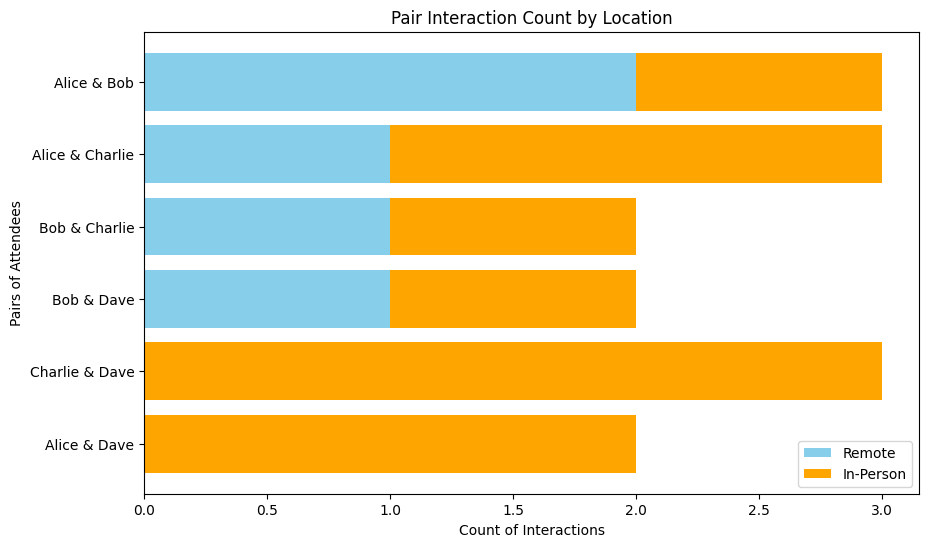

In [12]:
# Convert the meeting count dictionary to a sorted list of tuples
sorted_meeting_count = sorted(meeting_count.items(), key=lambda x: (-x[1]['remote'], -x[1]['in-person']))

# Extract data for plotting after sorting
pairs = [f'{pair[0]} & {pair[1]}' for pair, _ in sorted_meeting_count]
remote_counts = [count['remote'] for _, count in sorted_meeting_count]
in_person_counts = [count['in-person'] for _, count in sorted_meeting_count]

# Create the stacked bar chart
plt.figure(figsize=(10, 6))
plt.barh(pairs, remote_counts, color='skyblue', label='Remote')
plt.barh(pairs, in_person_counts, left=remote_counts, color='orange', label='In-Person')

plt.xlabel('Count of Interactions')
plt.ylabel('Pairs of Attendees')
plt.title('Pair Interaction Count by Location')
plt.legend()
plt.gca().invert_yaxis()  # To display the pair with the most interactions at the top
plt.show()
